In [65]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def load_dataset(file_path, max_rows=None):
    """
    从 JSON 文件加载数据，并转化为 Pandas DataFrame。
    
    Args:
        file_path (str): JSON 文件路径。
        max_rows (int): 加载的最大行数（用于调试或快速测试）。

    Returns:
        pd.DataFrame: 包含数据的 DataFrame。
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(tqdm(f, desc="Loading dataset")):
            if max_rows and idx >= max_rows:
                break
            record = json.loads(line.strip())
            data.append(record)
    return pd.DataFrame(data)

def preprocess_data(df, label_column):
    """
    数据预处理，包括分离特征和标签，以及数据划分。
    
    Args:
        df (pd.DataFrame): 原始数据的 DataFrame。
        label_column (str): 用于预测的标签列。

    Returns:
        X_train, X_test, y_train, y_test: 训练集和测试集的特征与标签。
    """
    # 提取特征和标签
    X = df['abstract']
    y = df[label_column]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

def train_random_forest(X_train_tfidf, y_train):
    """
    使用随机森林训练模型。
    
    Args:
        X_train_tfidf: TF-IDF 转换后的训练集特征。
        y_train (pd.Series): 训练集标签。

    Returns:
        model (RandomForestClassifier): 训练好的随机森林模型。
    """
    # 随机森林模型训练
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_tfidf, y_train)
    
    return model

def train_xgboost(X_train_tfidf, y_train):
    """
    使用 XGBoost 训练模型。
    
    Args:
        X_train_tfidf: TF-IDF 转换后的训练集特征。
        y_train (pd.Series): 训练集标签。

    Returns:
        model (XGBClassifier): 训练好的 XGBoost 模型。
    """
    # XGBoost 模型训练
    model = XGBClassifier(
        objective='multi:softmax',  # 多分类问题
        verbosity=2,               # 显示训练过程
        random_state=42,         # 固定随机种子
        n_jobs=-1,                # 使用多线程
        eval_metric='mlogloss'   # 评估指标
    )
    model.fit(X_train_tfidf, y_train)
    
    return model

def evaluate_model(model, X_test_tfidf, y_test, label_name):
    """
    评估模型性能。
    
    Args:
        model: 训练好的模型。
        X_test_tfidf: TF-IDF 转换后的测试集特征。
        y_test (pd.Series): 测试集标签。
        label_name (str): 当前使用的标签名称（Scopus_label 或 cluster_label）。

    Returns:
        dict: 包含性能指标的字典。
    """
    # make prediction
    y_pred = model.predict(X_test_tfidf)
    # print performance metrics
    print(f"results using label {label_name}：")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy：{accuracy:.4f}")

In [70]:
import sys
sys.path.append("clustering")

import os
from utils import get_data_dir, prinT
import nltk

# Step 1: Load dataset
dataset_path = os.path.join(get_data_dir(), "2010s","dataset.json")
prinT("Start loading dataset")
df = load_dataset(dataset_path, max_rows=10000)  # limit rows for quick testing
prinT("Dataset loaded")

# Step 2: split data (keep same X_train, X_test for both labels)
X_train, X_test, _, _ = preprocess_data(df, label_column='Scopus_label')

# Step 3: construct TF-IDF vectorizer
prinT("Constructing TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(max_features=None, stop_words=nltk.corpus.stopwords.words('english'))
X_train_tfidf = vectorizer.fit_transform(X_train)  # only fit on training data
X_test_tfidf = vectorizer.transform(X_test)  # transform on test data
prinT("TF-IDF finished")

data_dir:  /home/lyuzhuoqi/projects/clustering/data
2024-11-22 00:54:31 -- Start loading dataset


Loading dataset: 10000it [00:00, 249140.43it/s]

2024-11-22 00:54:31 -- Dataset loaded
2024-11-22 00:54:31 -- Constructing TF-IDF vectorizer...


2024-11-22 00:54:31 -- TF-IDF finished


In [30]:
df['cluster_label'].value_counts()

cluster_label
23    8297
22    6669
15    4706
0     3758
20    3097
12    2556
18    2414
8     1897
5     1780
3     1716
16    1426
13    1311
9     1252
21    1126
19    1098
10    1006
1      979
2      933
24     863
11     714
17     616
4      610
7      396
25     373
14     264
6      143
Name: count, dtype: int64

In [34]:
df[df['cluster_label']==23]['Scopus_label'].value_counts()

Scopus_label
Chemistry                                       2426
Materials Science                               2335
Physics and Astronomy                           1970
Chemical Engineering                             616
Energy                                           270
Engineering                                      231
Environmental Science                            129
Multidisciplinary                                123
Medicine                                          93
Biochemistry, Genetics and Molecular Biology      43
Agricultural and Biological Sciences              19
Earth and Planetary Sciences                      19
Mathematics                                        6
Health Professions                                 6
Arts and Humanities                                3
Social Sciences                                    3
Pharmacology, Toxicology and Pharmaceutics         2
Immunology and Microbiology                        2
Nursing                          

In [35]:
df[df['cluster_label']==22]['Scopus_label'].value_counts()

Scopus_label
Biochemistry, Genetics and Molecular Biology    2445
Medicine                                        1134
Multidisciplinary                                929
Pharmacology, Toxicology and Pharmaceutics       817
Immunology and Microbiology                      672
Chemistry                                        337
Nursing                                          104
Agricultural and Biological Sciences              90
Engineering                                       64
Computer Science                                  21
Environmental Science                             16
Mathematics                                       11
Social Sciences                                   11
Materials Science                                  9
Chemical Engineering                               4
Neuroscience                                       3
Veterinary                                         2
Name: count, dtype: int64

In [12]:
# Step 3: train model and evaluate
label_column = 'Scopus_label'
print(f"\nStart preprocessing label columns：{label_column}")
_, _, y_train, y_test = preprocess_data(df, label_column=label_column)
prinT("Start training model")
model = train_random_forest(X_train_tfidf, y_train)
prinT("Model trained")


Start preprocessing label columns：Scopus_label
2024-11-21 23:39:46 -- Start training model


2024-11-21 23:39:57 -- Model trained


results using label Scopus_label：
                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences       0.51      0.58      0.54       601
                         Arts and Humanities       0.36      0.14      0.21       167
Biochemistry, Genetics and Molecular Biology       0.50      0.37      0.43       560
         Business, Management and Accounting       0.62      0.24      0.35       132
                        Chemical Engineering       0.50      0.02      0.04       144
                                   Chemistry       0.50      0.53      0.51       563
                            Computer Science       0.44      0.03      0.06       228
                           Decision Sciences       0.00      0.00      0.00        23
                                   Dentistry       0.00      0.00      0.00        64
                Earth and Planetary Sciences       0.65      0.22      0.33       243
         Economics,

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

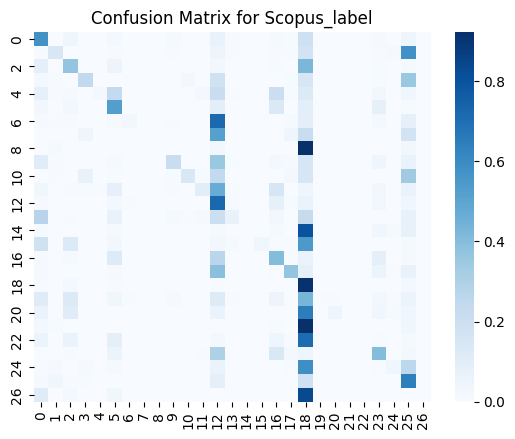

In [15]:
evaluate_model(model, X_test_tfidf, y_test, label_column)

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f"Confusion Matrix for {label_column}")
plt.show()

In [72]:
label_column = 'cluster_label'
print(f"\nStart preprocessing label columns：{label_column}")
_, _, y_train, y_test = preprocess_data(df, label_column=label_column)
prinT("Start training model")
model = train_random_forest(X_train_tfidf, y_train)
# model = train_xgboost(X_train_tfidf, y_train)
prinT("Model trained")


Start preprocessing label columns：cluster_label
2024-11-22 00:57:22 -- Start training model
2024-11-22 00:57:25 -- Model trained


In [51]:
X_train.values[3]

'The aim of this work was to study, from a sociological approach, the perception and consumption motives of amaranth in Mexico using Pierre Bourdieu\'s theoretical concept of Habitus. A survey was conducted in Mexico City with 610 consumers. Socioeconomic information of gender, age, cultural and economic capitals as internal dispositions that generate social differentiation processes were collected. Consumers\' perception was identified using an open question through which participants mentioned why they consider the consumption of amaranth to be good. Words, phrases or comments mentioned were grouped into categories through the lemmatization process, and analysed with Global, Per-Cell Chi Square tests and Correspondence Analysis. A Food Choice Questionnaire was used to identify consumption motives of amaranth through Exploratory Factor Analysis and Cluster analysis to identify groups of consumers according to their consumption motives. Results indicated eight categories that reflect c

In [43]:
y_train

10738    15
35155    23
22780     8
11163    12
22154    23
         ..
34043    23
3590     20
49718    21
889       1
22967     8
Name: cluster_label, Length: 40000, dtype: int64

results using label cluster_label：
              precision    recall  f1-score   support

           0       0.14      0.01      0.01       134
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00        66
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        71
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        78
           9       0.00      0.00      0.00        53
          10       0.00      0.00      0.00        42
          11       0.00      0.00      0.00        26
          12       0.00      0.00      0.00       101
          13       0.00      0.00      0.00        51
          14       0.00      0.00      0.00        13
          15       0.06      0.02      0.03       180
          16       0.00      0.00      0.00   

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

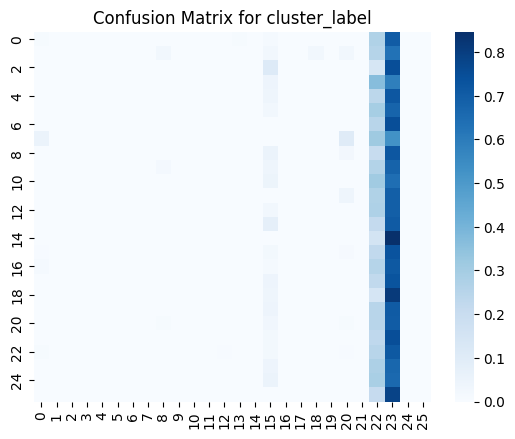

In [73]:
evaluate_model(model, X_test_tfidf, y_test, label_column)

y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f"Confusion Matrix for {label_column}")
plt.show()